This notebook show how to convert the trained [**StarGANv1**](https://arxiv.org/pdf/1711.09020.pdf) model into model runnable on iOS device.

To run the model on the iOS I use Apple [**CoreML**](https://developer.apple.com/documentation/coreml) framework. This framework allows to run different ML models (including neural networks) on all Apple devices (iOS, OSX, watchOS, tvOS).

CoreML has its own model format called **.mlmodel** which is constructed using protobuf-like protocol. Currently it [supports](https://apple.github.io/coremltools/coremlspecification/sections/NeuralNetwork.html) many layers and almost any model can be converted to it if putting enough efforts.

StarGANv1 model [**implementation**](https://github.com/yunjey/stargan) I use is written in PyTorch. There is no mature framework for direct conversion between PyTorch and CoreML. Yet [**ONNX**](https://github.com/onnx/onnx) can help a lot here. The pipeline which is shown in this notebook is:
```
PyTorch -> ONNX -> CoreML
```

To run the model on the Android device one should use TFLite model format which can be obtained using the `PyTorch -> ONNX -> TF -> TFLite` pipeline. But it falls out of this notebook scope.

# Imports

Imort necessary libraries

In [1]:
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.extend(["../code/", "../stargan/"])

import numpy as np

import torch
import torchvision.transforms as T

import onnx
import onnx_coreml

from PIL import Image
import matplotlib.pyplot as plt

from config import get_config

from solver import Solver

/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

# Load model

Let's first load the config for the model. It is mostly default except for the model checkpoint path.

In [2]:
config = get_config("""
--model_save_dir ../models/celeba_128_custom/
--test_iters 160000
--c_dim 9
--selected_attrs Black_Hair Blond_Hair Brown_Hair Gray_Hair Bald Bangs Receding_Hairline Straight_Hair Wavy_Hair
""")

Load the model architecture with the provided config.

In [3]:
model = Solver(None, None, config)

Generator(
  (main): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Restore model weights.

In [4]:
model.restore_model(model.test_iters)

Loading the trained models from step 160000...


# Embed pre/post processing into the graph

In usual PyTorch model the **preprocessing is done outside the model graph**. It allows to prepare the images in multiple threads and put them in queue. With this approach the GPU utilization would be the highest because it does not wait for images to be prepared but takes it already prepared right out of the queue. It allows for faster processing of huge amounts of data which might be common task in cloud.

But in mobile devices the batch processing of the huge amount of images is a very rare task. The usage pattern is usually one image at a time. Plus writing a mobile code (especially in Swift) which works with images and do all the preprocessing steps might be painful. Thus it is a good idea to **include all the preprocessing steps inside the model graph**.

To do so I create a separate PyTorch model for both **Discriminator and Generator**. Note that both of these classes also includes postprocessing: **denormalization** for generator and applying **sigmoid** for discriminator.

In [5]:
class GeneratorWithProcessing(torch.nn.Module):
    """ Model wrapper for the Generator pre and post processing steps.
    """
    
    def __init__(self, G):
        """ Constructor.
        
        Args:
            G (torch.nn.Module): Generator model which is used for inference.
        """
        super().__init__()
        self.G = G

    def forward(self, x, c):
        """ Forward pass function.
        
        Args:
            x (torch.tensor): image in the format CxHxW and pixel values in range [0...255]
            c (torch.tensor): style vector
        
        Returns:
            torch.tensor: the output image in the format CxHxW and pixel values in range [0...255]
        """
        return (self.G((x.float() / 255 - 0.5) / 0.5, c) + 1 ) / 2 * 255


class DiscriminatorWithProcessing(torch.nn.Module):
    """ Model wrapper for the Discriminator pre and post processing steps.
    """
    
    def __init__(self, D):
        """ Constructor.
        
        Args:
            D (torch.nn.Module): Discriminator model which is used for inference.
        """
        super().__init__()
        self.D = D

    def forward(self, x):
        """ Forward pass function.
        
        Args:
            x (torch.tensor): image in the format CxHxW and pixel values in range [0...255]
        
        Returns:
            torch.tensor: style vector
        """
        _, style = self.D((x.float() / 255 - 0.5) / 0.5)
        return torch.sigmoid(style)

Initialize new models

In [6]:
G_custom = GeneratorWithProcessing(model.G)
D_custom = DiscriminatorWithProcessing(model.D)

# Convert to ONNX

Now let's convert both models to ONNX format

In [7]:
torch.onnx.export(
    model=G_custom, 
    args=(torch.rand(1, 3, 128, 128), torch.rand(1, 9)),
    f="G.onnx",
    opset_version=9,
    verbose=False,
    input_names=["image", "style"],
    output_names=["output"]
)

torch.onnx.export(
    model=D_custom, 
    args=torch.rand(1, 3, 128, 128),
    f="D.onnx",
    opset_version=9,
    verbose=False,
    input_names=["image"],
    output_names=["output"]
)

Check that models are OK

In [8]:
onnx.checker.check_model(onnx.load_model("G.onnx"))
onnx.checker.check_model(onnx.load_model("D.onnx"))

# Convert to CoreML

Now let's convert both models to CoreML framework

In [9]:
G_coreml = onnx_coreml.convert(model="G.onnx", 
                               mode=None,
                               image_input_names=["image"], 
                               preprocessing_args={"is_bgr": False}, 
                               minimum_ios_deployment_target="13", 
                               image_output_names=["output"])

D_coreml = onnx_coreml.convert(model="D.onnx", 
                               mode=None,
                               image_input_names=["image"], 
                               preprocessing_args={"is_bgr": False}, 
                               minimum_ios_deployment_target="13")

1/62: Converting Node Type Div
2/62: Converting Node Type Sub
3/62: Converting Node Type Div
4/62: Converting Node Type Reshape
5/62: Converting Node Type Tile
6/62: Converting Node Type Concat
7/62: Converting Node Type Conv
8/62: Converting Node Type InstanceNormalization
9/62: Converting Node Type Relu
10/62: Converting Node Type Conv
11/62: Converting Node Type InstanceNormalization
12/62: Converting Node Type Relu
13/62: Converting Node Type Conv
14/62: Converting Node Type InstanceNormalization
15/62: Converting Node Type Relu
16/62: Converting Node Type Conv
17/62: Converting Node Type InstanceNormalization
18/62: Converting Node Type Relu
19/62: Converting Node Type Conv
20/62: Converting Node Type InstanceNormalization
21/62: Converting Node Type Add
22/62: Converting Node Type Conv
23/62: Converting Node Type InstanceNormalization
24/62: Converting Node Type Relu
25/62: Converting Node Type Conv
26/62: Converting Node Type InstanceNormalization
27/62: Converting Node Type Add

# Comparison

Now let's compare the very initial model with the final CoreML model.

**Note that CoreML model can be executed only on Mac** (not inside the Docker on Mac, but simply on Mac).

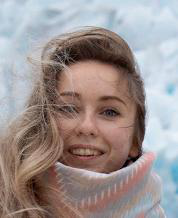

In [10]:
image = Image.open("../data/test.jpg")
image

## PyTorch

Transformation for initial PyTorch model

In [11]:
transform_pth = []
transform_pth.append(T.Resize(128))
transform_pth.append(T.CenterCrop(128))
transform_pth.append(T.ToTensor())
transform_pth.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform_pth = T.Compose(transform_pth)

Get input for PyTorch network

In [12]:
x_real_pth = torch.stack([transform_pth(image)])
x_real_pth

tensor([[[[ 0.4353,  0.4510,  0.4745,  ...,  0.6471,  0.6235,  0.6157],
          [ 0.4431,  0.4588,  0.4745,  ...,  0.6314,  0.6314,  0.6314],
          [ 0.4667,  0.4667,  0.4824,  ...,  0.6000,  0.6157,  0.6392],
          ...,
          [ 0.2078,  0.0980, -0.0824,  ...,  0.1529,  0.1216,  0.1059],
          [ 0.2000,  0.0745,  0.0196,  ...,  0.1765,  0.2078,  0.2471],
          [ 0.1294,  0.0667,  0.1059,  ...,  0.1686,  0.2314,  0.3098]],

         [[ 0.5765,  0.5922,  0.6157,  ...,  0.7569,  0.7333,  0.7255],
          [ 0.5843,  0.6000,  0.6157,  ...,  0.7490,  0.7490,  0.7412],
          [ 0.6078,  0.6078,  0.6235,  ...,  0.7255,  0.7333,  0.7490],
          ...,
          [-0.0118, -0.1216, -0.3020,  ...,  0.4431,  0.4431,  0.4275],
          [-0.0196, -0.1451, -0.2000,  ...,  0.4667,  0.4980,  0.4980],
          [-0.0745, -0.1373, -0.0980,  ...,  0.4588,  0.4980,  0.5059]],

         [[ 0.6863,  0.7020,  0.7255,  ...,  0.8431,  0.8275,  0.8196],
          [ 0.6941,  0.7098,  

Calculate eigen style vector

In [13]:
with torch.no_grad():
    eigen_style_vector_pth = torch.sigmoid(model.D(x_real_pth)[1])

for proba, tag in zip(eigen_style_vector_pth.numpy()[0], model.selected_attrs):
    print(f"{tag:20}: {proba:.3f}")

Black_Hair          : 0.001
Blond_Hair          : 0.116
Brown_Hair          : 0.143
Gray_Hair           : 0.000
Bald                : 0.000
Bangs               : 0.000
Receding_Hairline   : 0.073
Straight_Hair       : 0.056
Wavy_Hair           : 0.248


Generate image with eigen style vector

In [14]:
with torch.no_grad():
    res_eigen_pth = model.G(x_real_pth, eigen_style_vector_pth)
res_eigen_pth

tensor([[[[ 0.5862,  0.6157,  0.6036,  ...,  0.8491,  0.8461,  0.8025],
          [ 0.6036,  0.5981,  0.6060,  ...,  0.8408,  0.8796,  0.8469],
          [ 0.5973,  0.6309,  0.6409,  ...,  0.8236,  0.8521,  0.8264],
          ...,
          [ 0.1676,  0.0914,  0.0621,  ...,  0.2404,  0.2629,  0.2020],
          [ 0.1636,  0.0973,  0.0849,  ...,  0.2490,  0.2980,  0.2601],
          [ 0.1421,  0.0821,  0.0741,  ...,  0.2877,  0.3266,  0.2748]],

         [[ 0.7242,  0.7843,  0.8007,  ...,  0.9426,  0.9223,  0.8603],
          [ 0.7577,  0.7968,  0.8115,  ...,  0.9509,  0.9470,  0.9081],
          [ 0.7923,  0.8311,  0.8401,  ...,  0.9604,  0.9487,  0.9144],
          ...,
          [-0.0518, -0.1163, -0.1386,  ...,  0.4839,  0.4849,  0.4553],
          [-0.0600, -0.1344, -0.1298,  ...,  0.4667,  0.5020,  0.4833],
          [-0.0491, -0.1185, -0.1292,  ...,  0.4855,  0.5060,  0.4563]],

         [[ 0.8096,  0.8795,  0.9038,  ...,  0.9767,  0.9621,  0.9111],
          [ 0.8629,  0.8985,  

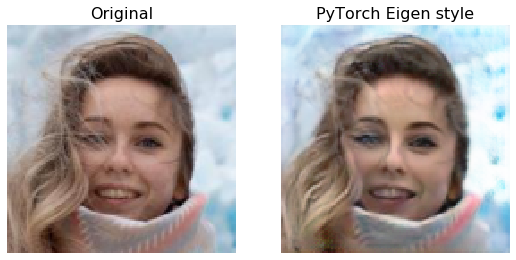

In [15]:
plt.figure(figsize=(9, 8))

plt.subplot(121)
_img = model.denorm(x_real_pth).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Original", fontsize=16)

plt.subplot(122)
_img = model.denorm(res_eigen_pth).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("PyTorch Eigen style", fontsize=16);

## CoreML

Transformation for CoreML model

In [16]:
transform_coreml = []
transform_coreml.append(T.Resize(128))
transform_coreml.append(T.CenterCrop(128))
transform_coreml = T.Compose(transform_coreml)

Get input for CoreML model

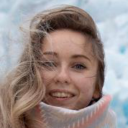

In [17]:
x_real_coreml = transform_coreml(image)
x_real_coreml

Calculate eigen style vector.

The output of the **CoreML** Discriminator model is almost **the same** as in the initial **PyTorch** model. It means the the Discriminator is correctly converted.

In [18]:
eigen_style_vector_coreml = D_coreml.predict({"image": x_real_coreml})["output"]

for proba, tag in zip(eigen_style_vector_coreml[0], model.selected_attrs):
    print(f"{tag:20}: {proba:.3f}")

Black_Hair          : 0.001
Blond_Hair          : 0.117
Brown_Hair          : 0.143
Gray_Hair           : 0.000
Bald                : 0.000
Bangs               : 0.000
Receding_Hairline   : 0.073
Straight_Hair       : 0.056
Wavy_Hair           : 0.249


Generate image with eigen style vector

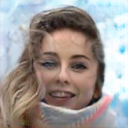

In [19]:
res_eigen_coreml = G_coreml.predict({"image": x_real_coreml, 
                                     "style": eigen_style_vector_coreml})["output"]
res_eigen_coreml

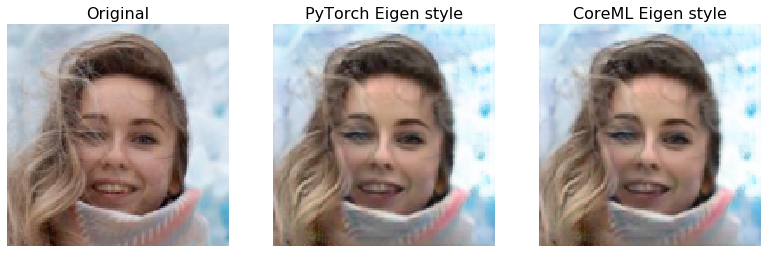

In [20]:
plt.figure(figsize=(13.5, 8))

plt.subplot(131)
_img = model.denorm(x_real_pth).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Original", fontsize=16)

plt.subplot(132)
_img = model.denorm(res_eigen_pth).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("PyTorch Eigen style", fontsize=16);

plt.subplot(133)
_img = np.array(res_eigen_coreml)
plt.imshow(_img)
plt.axis("off")
plt.title("CoreML Eigen style", fontsize=16);

The outputs of both Discriminator and Generator are the same. It means that both networks are correctly converted.

# Save CoreML models

Let's finally save CoreML models.

In [21]:
G_coreml.save("G.mlmodel")
D_coreml.save("D.mlmodel")